In [117]:
import json
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt
import math

In [122]:
def get_data_files(path, regex):
    """Retrieves all data files that match the ``regex`` in the
    directory specified by ``path``.
    """
    return [
        join(path, f)
        for f in listdir(path)
        if (f.endswith(".json") and isfile(join(path, f)) and bool(re.match(regex, f)))
    ]

def read_json(filename):
    """Reads data from a JSON file.
    :param filename: The path to the JSON file. Note this string must contain the ``.json`` extension.
    :type filename: string
    :returns: The dictionary read from the JSON file.
    :rtype: dict
    """

    with open(filename) as file:
        data_dict = json.load(file)

    return data_dict

def get_nonnegative_rank_data(path, n_range, noise_regex=r""):

    data_dicts = []
    arg_mins = []
    for i in n_range:
        regex = r"^n_" + str(i) + noise_regex + r"_\d\d\d\d-\d\d-\d\dT\d\d-\d\d-\d\dZ"
        
        files = get_data_files(path, regex)
        nmf_dicts = [read_json(file) for file in files]
        data_dicts += [nmf_dicts]
        arg_mins += [np.argmin([data_dict["k"] for data_dict in nmf_dicts])]

    return data_dicts, arg_mins

In [123]:
data_path = "../data/nonnegative_rank/qubit_planar_symmetric/"
n_range = range(2, 38)
noisy_n_range  = range(3,23)

nmf_data_dicts, nmf_arg_mins = get_nonnegative_rank_data(data_path, n_range)
nmf_01_data_dicts, nmf_01_arg_mins = get_nonnegative_rank_data(data_path, noisy_n_range, noise_regex=r"_noisy_01_")
nmf_05_data_dicts, nmf_05_arg_mins = get_nonnegative_rank_data(data_path, noisy_n_range, noise_regex=r"_noisy_05_")
nmf_10_data_dicts, nmf_10_arg_mins = get_nonnegative_rank_data(data_path, noisy_n_range, noise_regex=r"_noisy_10_")



min_nmf_data_dicts = [
    nmf_data_dicts[i][nmf_arg_mins[i]]
    for i in range(len(nmf_data_dicts))
]
min_nmf_01_data_dicts = [
    nmf_01_data_dicts[i][nmf_01_arg_mins[i]]
    for i in range(len(nmf_01_data_dicts))
]
min_nmf_05_data_dicts = [
    nmf_05_data_dicts[i][nmf_05_arg_mins[i]]
    for i in range(len(nmf_05_data_dicts))
]
min_nmf_10_data_dicts = [
    nmf_10_data_dicts[i][nmf_10_arg_mins[i]]
    for i in range(len(nmf_10_data_dicts))
]

min_nmf_k = [data_dict["k"] for data_dict in min_nmf_data_dicts]
min_nmf_01_k = [data_dict["k"] for data_dict in min_nmf_01_data_dicts]
min_nmf_05_k = [data_dict["k"] for data_dict in min_nmf_05_data_dicts]
min_nmf_10_k = [data_dict["k"] for data_dict in min_nmf_10_data_dicts]





In [124]:
def lb_k(n):
    k = 1
    while n > math.comb(k, int(np.floor(k/2))):
        k += 1
    
    return k

k_lbs = [lb_k(n) for n in n_range]

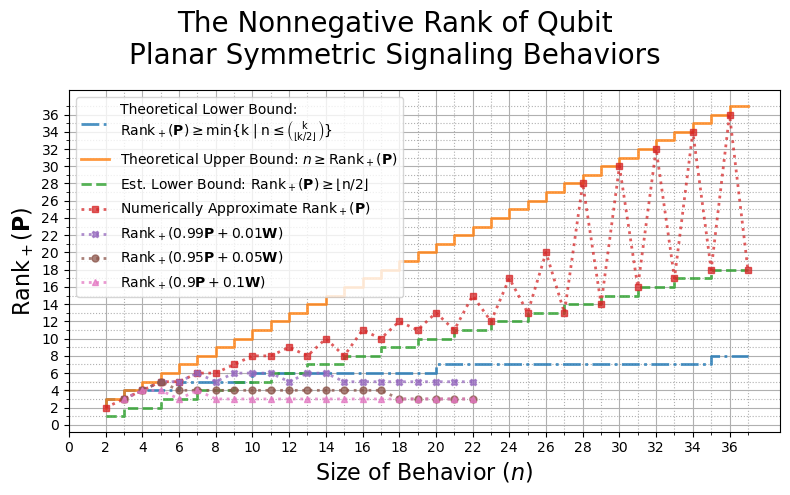

In [125]:
fig = plt.figure(figsize=(8,5))

plt.grid()
plt.grid(which="minor", linestyle=":")
plt.minorticks_on()

# plt.step(n_range, [np.ceil(np.log2(n)) for n in n_range], linestyle=":")
plt.step(n_range, k_lbs, linestyle="-.", label="Theoretical Lower Bound:\n"+r"$\rm{Rank}_+(\mathbf{P}) \geq \min\{k\;|\; n\leq \binom{k}{\lfloor k/2 \rfloor}\}$", linewidth=2, alpha=0.8)
plt.step(n_range, n_range, label=r"Theoretical Upper Bound: $n \geq \rm{Rank}_+(\mathbf{P})$", linewidth=2, alpha=0.8)
plt.step(n_range, [np.floor(n/2) for n in n_range], linestyle="--", label=r"Est. Lower Bound: $\rm{Rank}_+(\mathbf{P}) \geq \lfloor n/2 \rfloor$", linewidth=2, alpha=0.8)

plt.plot(n_range, min_nmf_k, linestyle=":", marker="s", label=r"Numerically Approximate $\rm{Rank}_+(\mathbf{P})$", linewidth=2, markersize=5, alpha=0.75)
plt.plot(noisy_n_range, min_nmf_01_k, linestyle=":", marker="X", label=r"$\rm{Rank}_+(0.99 \mathbf{P} + 0.01 \mathbf{W})$", linewidth=2, markersize=5, alpha=0.75)
plt.plot(noisy_n_range, min_nmf_05_k, linestyle=":", marker="o", label=r"$\rm{Rank}_+(0.95 \mathbf{P} + 0.05 \mathbf{W})$", linewidth=2, markersize=5, alpha=0.75)
plt.plot(noisy_n_range, min_nmf_10_k, linestyle=":", marker="^", label=r"$\rm{Rank}_+(0.9 \mathbf{P} + 0.1 \mathbf{W})$", linewidth=2, markersize=5, alpha=0.75)


plt.xticks(range(0, 38, 2))
plt.xticks(range(3, 38, 2), minor=True)
plt.yticks(range(0,38,2))
plt.yticks(range(1, 38, 2), minor=True)

plt.ylabel(r"$\rm{Rank}_+(\mathbf{P})$",fontsize=16)
plt.xlabel(r"Size of Behavior ($n$)", fontsize=16)

plt.legend()
fig.suptitle("The Nonnegative Rank of Qubit\nPlanar Symmetric Signaling Behaviors", fontsize=20)

plt.tight_layout()

